In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from librosa.feature import mfcc
from tensorflow.keras.utils import to_categorical
import gdown
import pickle
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense

2023-06-06 18:48:14.492877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Produto

## Classificador de sentimento em arquivos de audio

### a) Qual é o problema que esse produto resolve?

    Identificar e classificar emoções em falas presentes em arquivos de audio

### b) Qual é o público a que o produto atende?
    
    O publico-alvo deste produto é qualquer empresa que tenha interesse em melhorar seu atendimento ao consumidor, ou processos de telemarketing.




#### c) Como esse produto se relaciona a machine learning?

    Esse produto se relaciona a machine learning na maneira como é tratado e desenvolvido. Para chegar no resultado desejado, foi necessário angariar uma grande quantidade de dados no formato específico necessário, e devidamente classificados, a fim de treinar diferentes modelos de machine learning utilizando técnicas de NLP.


# Base de dados

## Para este problema, foram escolhidas duas bases de dados: RAVDESS e SAVEE

In [2]:
RAVDESS = "./RAVDESS/audio_speech_actors_01-24/"
ravdess_dir_lis = os.listdir(RAVDESS)

path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}



for root, dirs, files in os.walk(RAVDESS):
    for file in files:
        if file == '.DS_Store':
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()


,path,sex,emotion
0,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,neutral
1,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,happy
2,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,happy
3,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,sad
4,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,disgust


In [3]:
ravdess_df = ravdess_df[ravdess_df['path'] !=  './RAVDESS/audio_speech_actors_01-24/Actor_16']

In [4]:
from pydub import AudioSegment, effects


classes = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
SAVEE = "./SAVEE/ALL/" 
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
            
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,./SAVEE/ALL/JK_sa01.wav,male,sad
1,./SAVEE/ALL/JK_sa15.wav,male,sad
2,./SAVEE/ALL/DC_n13.wav,male,neutral
3,./SAVEE/ALL/DC_n07.wav,male,neutral
4,./SAVEE/ALL/JK_n20.wav,male,neutral


In [6]:
full_df = pd.concat([ravdess_df, savee_df], axis = 0)

full_df.head()

,path,sex,emotion
0,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,neutral
1,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,happy
2,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,happy
3,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,sad
4,./RAVDESS/audio_speech_actors_01-24/Actor_11/0...,male,disgust


# Feature Extraction

Para a etapa de feature extraction, extraimos os MFCCs dos arquivos de audio, a fim de termos uma representação quantitativa dos fonemas na fala.

In [37]:
mfcc_vector = []
emotion_vector = []
for i in full_df.itertuples():
    
    y, sr = librosa.load(i.path)
    raw_audio = AudioSegment.from_file(i.path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 500000-len(trimmed)), 'constant')
    mfcc_ = librosa.feature.mfcc(y=padded, sr=sr, n_mfcc = 24, n_fft=512)
    mfcc_vector.append(mfcc_)
    emotion_vector.append(classes[i.emotion])

In [38]:
X = np.asarray(mfcc_vector)
y = np.asarray(emotion_vector)
y = np.expand_dims(y, axis=1).astype('int8')
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=None,stratify=y)


Y_train_ohe = to_categorical(Y_train,6)
Y_test_ohe = to_categorical(Y_test,6)

In [39]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5155, 24, 977)
(5155, 1)
(573, 24, 977)
(573, 1)


In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def matriz_confusao(y_test_hot_arg, y_est_argmax): # gera matriz
    cm = confusion_matrix(y_test_hot_arg, y_est_argmax, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# Modelo Baseline

In [40]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reshape the MFCC vectors into 2D format
X_train_2d = np.reshape(X_train, (X_train.shape[0], -1))
X_test_2d = np.reshape(X_test, (X_test.shape[0], -1))

# Create a Logistic Regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train_2d, Y_train)

# Predict on the test set
Y_pred = logreg.predict(X_test_2d)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.731239092495637


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
from joblib import dump
dump(logreg, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

# Deep Learning


In [49]:
model1 = Sequential()
model1.add(Input(shape=(24, 977)))
model1.add(LSTM(6, return_sequences=True))
model1.add(Dropout(0.3))
model1.add(LSTM(6))
model1.add(Dropout(0.3))
model1.add(Dense(6, activation='softmax', name='classificador'))
model1.compile(optimizer='adam', loss='categorical_crossentropy')
model1.summary()


model1.fit(X_train, Y_train_ohe, epochs = 50, batch_size=32, validation_split=0.2)

2023-06-06 20:08:47.787802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:08:47.790403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:08:47.792247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 6)             23616     
                                                                 
 dropout_4 (Dropout)         (None, 24, 6)             0         
                                                                 
 lstm_5 (LSTM)               (None, 6)                 312       
                                                                 
 dropout_5 (Dropout)         (None, 6)                 0         
                                                                 
 classificador (Dense)       (None, 6)                 42        
                                                                 
Total params: 23,970
Trainable params: 23,970
Non-trainable params: 0
_________________________________________________________________


2023-06-06 20:08:48.116434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:08:48.118684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:08:48.120437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-06-06 20:08:48.764813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:08:48.768829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:08:48.771146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

128/129 [============================>.] - ETA: 0s - loss: 1.7659

2023-06-06 20:08:58.941200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:08:58.943796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:08:58.945651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

129/129 [==============================] - 12s 39ms/step - loss: 1.7654 - val_loss: 1.7315
Epoch 2/50
129/129 [==============================] - 4s 32ms/step - loss: 1.6793 - val_loss: 1.6377
Epoch 3/50
129/129 [==============================] - 4s 28ms/step - loss: 1.5807 - val_loss: 1.5286
Epoch 4/50
129/129 [==============================] - 4s 34ms/step - loss: 1.4864 - val_loss: 1.4741
Epoch 5/50
129/129 [==============================] - 4s 32ms/step - loss: 1.4281 - val_loss: 1.3897
Epoch 6/50
129/129 [==============================] - 4s 31ms/step - loss: 1.3801 - val_loss: 1.3319
Epoch 7/50
129/129 [==============================] - 3s 26ms/step - loss: 1.2946 - val_loss: 1.2676
Epoch 8/50
129/129 [==============================] - 3s 26ms/step - loss: 1.2328 - val_loss: 1.1901
Epoch 9/50
129/129 [==============================] - 3s 24ms/step - loss: 1.1653 - val_loss: 1.1664
Epoch 10/50
129/129 [==============================] - 4s 29ms/step - loss: 1.1577 - val_loss: 1.1869

18/18 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        85
           1       0.97      0.94      0.95        97
           2       0.89      0.88      0.88        98
           3       0.86      0.89      0.87        98
           4       0.89      0.87      0.88        98
           5       0.89      0.84      0.86        97

    accuracy                           0.90       573
   macro avg       0.90      0.90      0.90       573
weighted avg       0.90      0.90      0.90       573



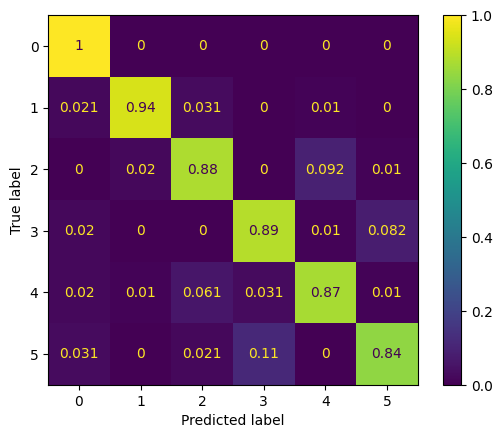

In [71]:
y_est = model1.predict(X_test)

y_est_argmax = np.argmax(y_est, axis=1)
y_test_hot_arg = np.argmax(Y_test_ohe, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_hot_arg, y_est_argmax))

acc_dict = classification_report(y_test_hot_arg, y_est_argmax,output_dict=True)

acc_dict['accuracy']

matriz_confusao(y_test_hot_arg, y_est_argmax)

model1.save("inhouse.h5")

# Modelo Pré-Treinado

In [51]:
from tensorflow.keras.models import load_model

# Load the saved model
pretrained = load_model('model.h5')

pretrained_out = pretrained.output





2023-06-06 20:12:07.782420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:12:07.785238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:12:07.787506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [68]:
from keras.models import Model
model = Dense(12)(pretrained_out)
model = Dense(24)(model)
model = Dense(6, activation = "softmax")(model)
output = Model(pretrained.input, model)
output.compile(optimizer='adam', loss='categorical_crossentropy')
output.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 977)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 6)                 23616     
                                                                 
 classificador (Dense)       (None, 6)                 42        
                                                                 
 dense_9 (Dense)             (None, 12)                84        
                                                                 
 dense_10 (Dense)            (None, 24)                312       
                                                                 
 dense_11 (Dense)            (None, 6)                 150       
                                                                 
Total params: 24,204
Trainable params: 24,204
Non-trainable

In [69]:
output.fit(X_train, Y_train_ohe, epochs = 50, batch_size=32, validation_split=0.2)

Epoch 1/50


2023-06-06 20:22:34.276848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:22:34.280281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:22:34.285176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

126/129 [============================>.] - ETA: 0s - loss: 1.0937

2023-06-06 20:22:41.123978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:22:41.127770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:22:41.130641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

129/129 [==============================] - 8s 34ms/step - loss: 1.0814 - val_loss: 0.5777
Epoch 2/50
129/129 [==============================] - 4s 34ms/step - loss: 0.3100 - val_loss: 0.2635
Epoch 3/50
129/129 [==============================] - 4s 29ms/step - loss: 0.1786 - val_loss: 0.2345
Epoch 4/50
129/129 [==============================] - 3s 21ms/step - loss: 0.2357 - val_loss: 0.4980
Epoch 5/50
129/129 [==============================] - 3s 20ms/step - loss: 0.3205 - val_loss: 0.4337
Epoch 6/50
129/129 [==============================] - 2s 19ms/step - loss: 0.2650 - val_loss: 0.3663
Epoch 7/50
129/129 [==============================] - 2s 18ms/step - loss: 0.2016 - val_loss: 0.2886
Epoch 8/50
129/129 [==============================] - 2s 17ms/step - loss: 0.1803 - val_loss: 0.3117
Epoch 9/50
129/129 [==============================] - 2s 18ms/step - loss: 0.1712 - val_loss: 0.4172
Epoch 10/50
129/129 [==============================] - 2s 18ms/step - loss: 0.1725 - val_loss: 0.2785


18/18 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        85
           1       0.88      0.95      0.91        97
           2       0.98      0.93      0.95        98
           3       0.96      0.99      0.97        98
           4       0.94      0.89      0.91        98
           5       0.95      0.93      0.94        97

    accuracy                           0.94       573
   macro avg       0.94      0.94      0.94       573
weighted avg       0.94      0.94      0.94       573



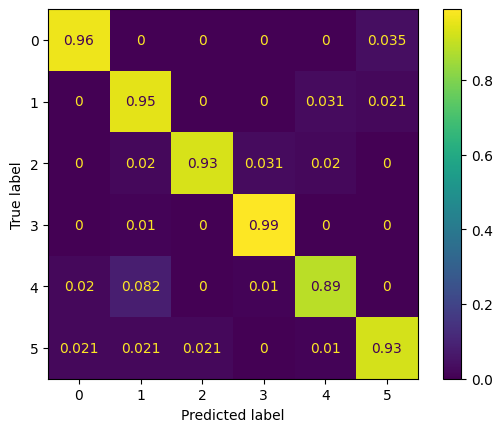

In [86]:
y_est = output.predict(X_test)

y_est_argmax = np.argmax(y_est, axis=1)
y_test_hot_arg = np.argmax(Y_test_ohe, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_hot_arg, y_est_argmax))

acc_dict = classification_report(y_test_hot_arg, y_est_argmax,output_dict=True)

acc_dict['accuracy']

matriz_confusao(y_test_hot_arg, y_est_argmax)
output.save("pretrained.h5")


In [73]:




print(classification_report(y_test_hot_arg, y_est_argmax))
    
    

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        85
           1       0.88      0.95      0.91        97
           2       0.98      0.93      0.95        98
           3       0.96      0.99      0.97        98
           4       0.94      0.89      0.91        98
           5       0.95      0.93      0.94        97

    accuracy                           0.94       573
   macro avg       0.94      0.94      0.94       573
weighted avg       0.94      0.94      0.94       573



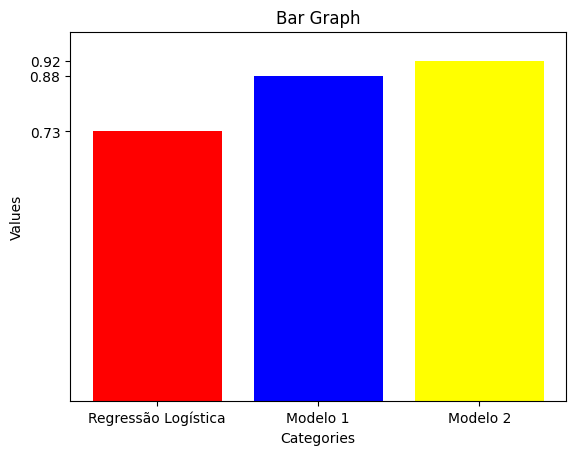

# Testes de tamanho e tempo

In [80]:
from joblib import load
model_1 = load_model("inhouse.h5")
model_2 = load_model("pretrained.h5")
lr_model = load('logistic_regression_model.joblib')




2023-06-06 20:52:02.679152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:52:02.680931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:52:02.682959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [84]:
import time

start_time = time.time()

# Perform the prediction
predictions = model_1.predict(X_test)

# End the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print("Prediction execution time:", execution_time, "seconds")

2023-06-06 20:53:13.536995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:53:13.541410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:53:13.544145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 1s 10ms/step
Prediction execution time: 1.2910878658294678 seconds


In [83]:
import time

start_time = time.time()

# Perform the prediction
predictions = model_2.predict(X_test)

# End the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print("Prediction execution time:", execution_time, "seconds")

2023-06-06 20:53:00.714119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 20:53:00.716144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 20:53:00.717684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 1s 9ms/step
Prediction execution time: 0.7801468372344971 seconds


In [85]:
import time

start_time = time.time()

# Perform the prediction
predictions = lr_model.predict(X_test_2d)

# End the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print("Prediction execution time:", execution_time, "seconds")

Prediction execution time: 0.14192819595336914 seconds
